<a href="https://colab.research.google.com/github/kk456699/Booking/blob/main/Speech_Emotional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nick125015","key":"27eb1cee15ee2754666940dbdaa07d67"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
! mkdir ravdess-emotional-speech-audio
! unzip ravdess-emotional-speech-audio.zip -d ravdess-emotional-speech-audio

! kaggle datasets download -d iitmcvg/cremad
! mkdir AudioWAV
! unzip cremad.zip -d AudioWAV

! kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
! unzip toronto-emotional-speech-set-tess.zip

! kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
! unzip surrey-audiovisual-expressed-emotion-savee.zip -d /content/

串流輸出內容已截斷至最後 5000 行。
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_life_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_limb_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_live_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_loaf_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_long_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_lore_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_lose_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_lot_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_love_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_luck_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_make_happy.wav  
  inflating: TESS Toronto emotional speech set data/OAF_happy/OAF_m

In [ ]:
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Paths for data.
Ravdess = "/content/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/content/AudioWAV/"
Tess = "/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/content/ALL/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprise  /content/ravdess-emotional-speech-audio/audio_...
1      fear  /content/ravdess-emotional-speech-audio/audio_...
2       sad  /content/ravdess-emotional-speech-audio/audio_...
3   neutral  /content/ravdess-emotional-speech-audio/audio_...
4      fear  /content/ravdess-emotional-speech-audio/audio_...

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Empty DataFrame
Columns: [Emotions, Path]
Index: []

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    happy  /content/tess toronto emotional speech set dat...
1    happy  /content/tess toronto emotional speech set dat...
2    happy  /content/tess toronto emotional speech set dat...
3    happy  /content/tess toronto emotional speech set dat...
4    happy  /content/tess toronto emotional speech set dat...

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                     Path
0     fear  /content/ALL/KL_f02.wav
1  neutral  /content/ALL/JE_n24.wav
2  disgust  /content/ALL/JK_d07.wav
3  neutral  /content/ALL/DC_n22.wav
4    angry  /content/ALL/KL_a03.wav

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /content/ravdess-emotional-speech-audio/audio_...
1      fear  /content/ravdess-emotional-speech-audio/audio_...
2       sad  /content/ravdess-emotional-speech-audio/audio_...
3   neutral  /content/ravdess-emotional-speech-audio/audio_...
4      fear  /content/ravdess-emotional-speech-audio/audio_...

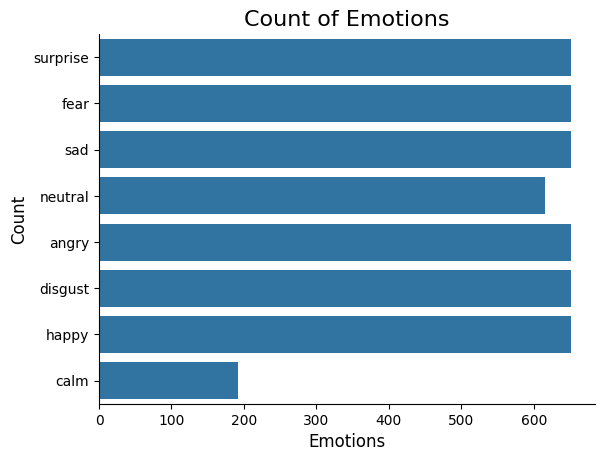

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(data)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

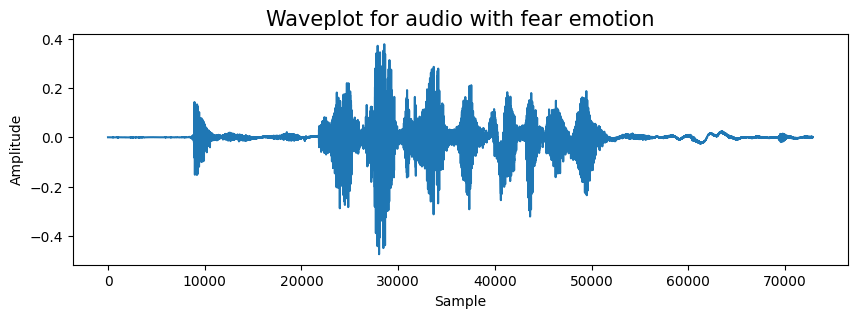

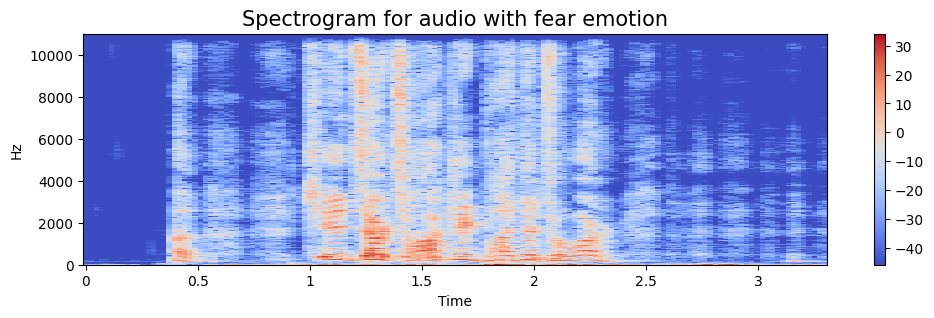

In [ ]:
file_name = '03-01-06-02-01-01-03.wav'
file_row = data_path[data_path['Path'].str.contains(file_name)]
if len(file_row) == 1:

    path = file_row['Path'].values[0]

    emotion = file_row['Emotions'].values[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


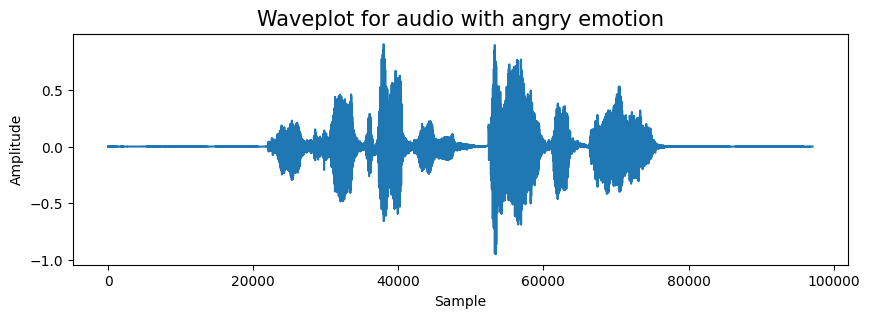

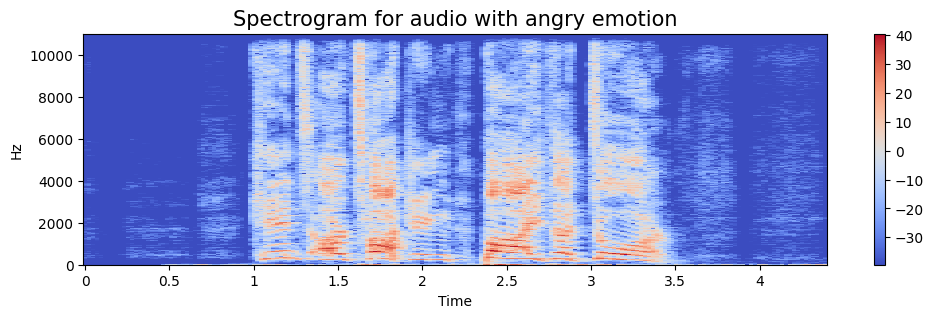

In [ ]:
file_name = '03-01-05-02-01-01-03.wav'
file_row = data_path[data_path['Path'].str.contains(file_name)]
if len(file_row) == 1:

    path = file_row['Path'].values[0]

    emotion = file_row['Emotions'].values[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

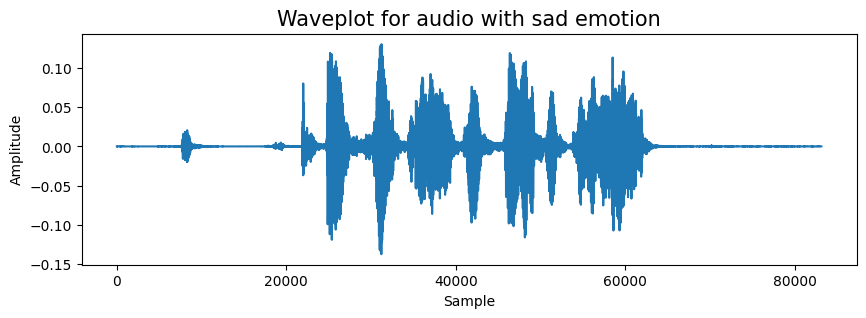

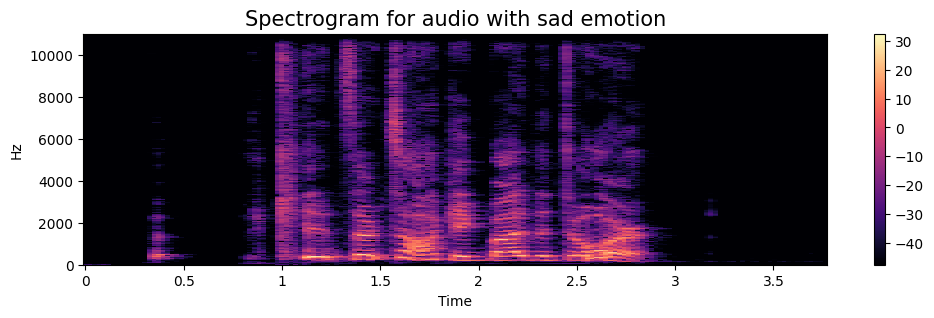

In [ ]:
file_name = '03-01-04-02-01-01-03.wav'
file_row = data_path[data_path['Path'].str.contains(file_name)]
if len(file_row) == 1:

    path = file_row['Path'].values[0]

    emotion = file_row['Emotions'].values[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

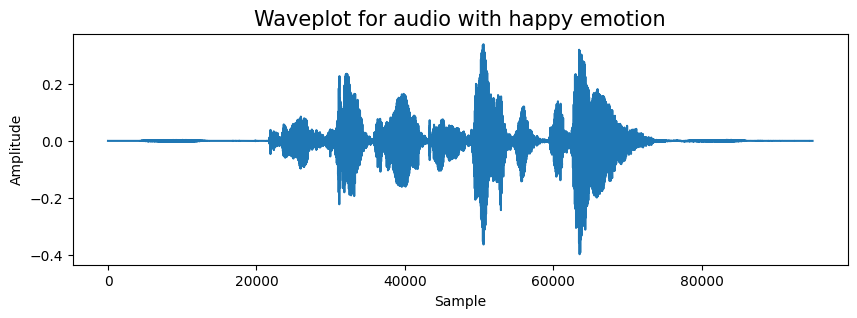

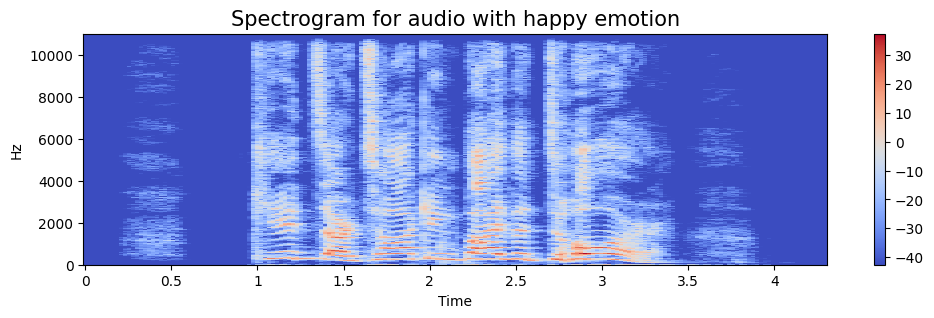

In [ ]:
file_name = '03-01-03-02-01-01-03.wav'
file_row = data_path[data_path['Path'].str.contains(file_name)]
if len(file_row) == 1:

    path = file_row['Path'].values[0]

    emotion = file_row['Emotions'].values[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def noise(data):
    noise_amp_factor = np.random.uniform(0.02, 0.05)
    noise_amp = noise_amp_factor * np.amax(data)
    noise_distribution = np.random.choice(['normal', 'uniform'])

    if noise_distribution == 'normal':
        noise_std = np.random.uniform(0.1, 0.3)
        noise = noise_amp * np.random.normal(loc=0, scale=noise_std, size=data.shape[0])
    elif noise_distribution == 'uniform':
        noise = noise_amp * np.random.uniform(size=data.shape[0])

    data = data + noise
    return data

def stretch(data):
    rate = np.random.uniform(0.85, 1.15)
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(-7,7)*1000)
    return np.roll(data, shift_range)


file_name = '03-01-03-02-01-01-03.wav'
file_row = data_path[data_path['Path'].str.contains(file_name)]
if len(file_row) == 1:

    path = file_row['Path'].values[0]

    emotion = file_row['Emotions'].values[0]
data, sampling_rate = librosa.load(path)

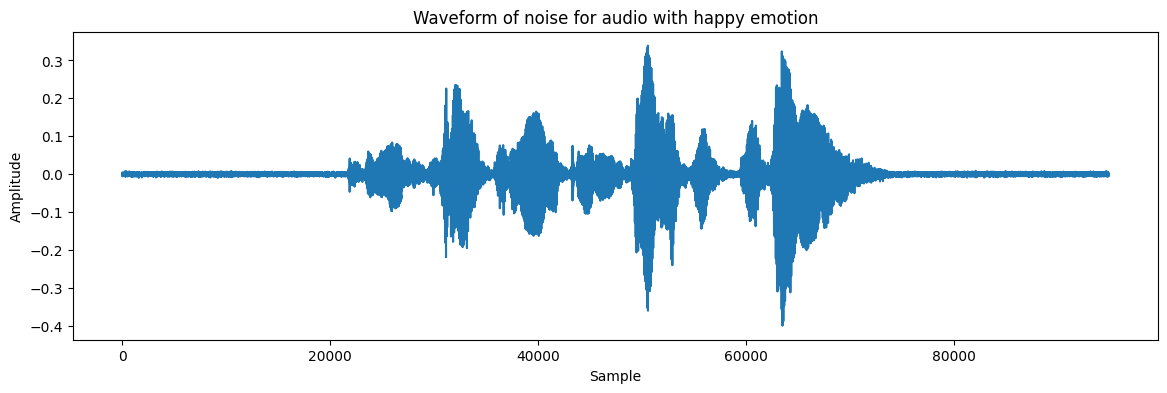

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveform of noise for audio with {} emotion'.format(emotion))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()
Audio(x,rate=sampling_rate)

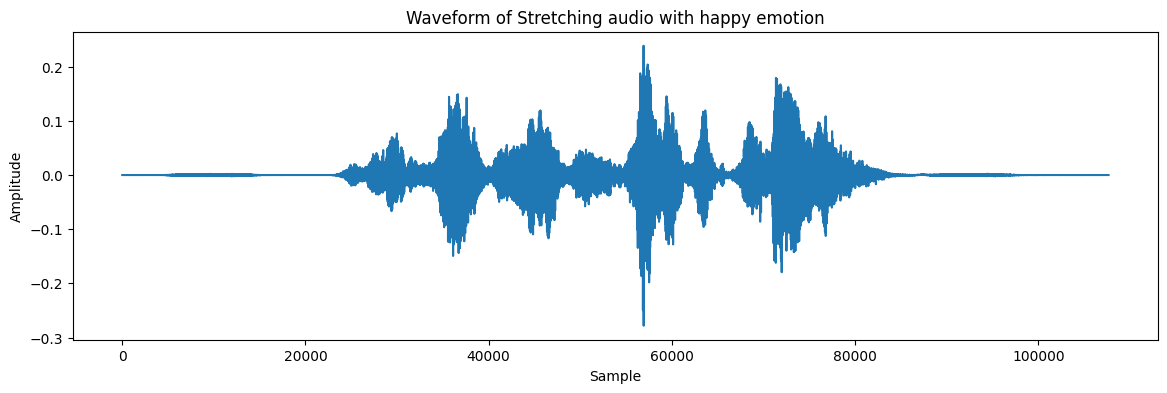

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform of Stretching audio with {} emotion'.format(emotion))
plt.show()
Audio(x,rate=sampling_rate)

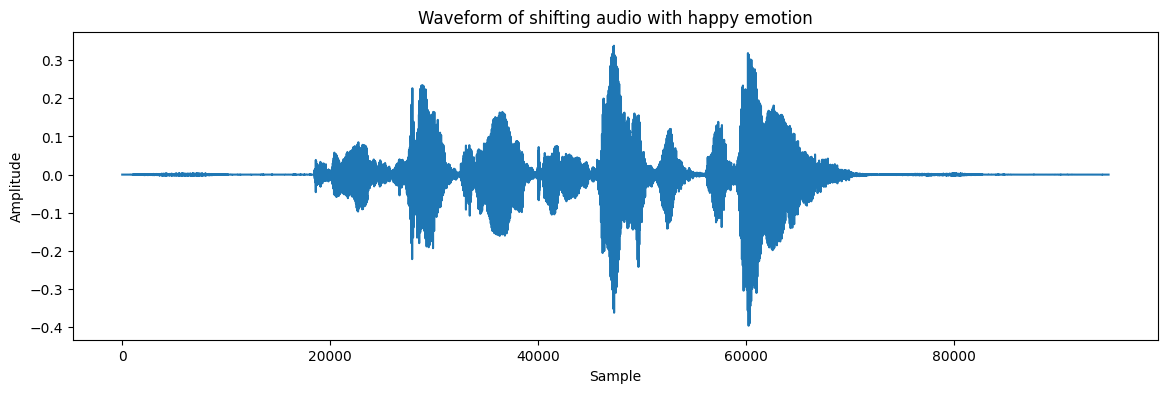

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform of shifting audio with {} emotion'.format(emotion))
plt.show()
Audio(x,rate=sampling_rate)

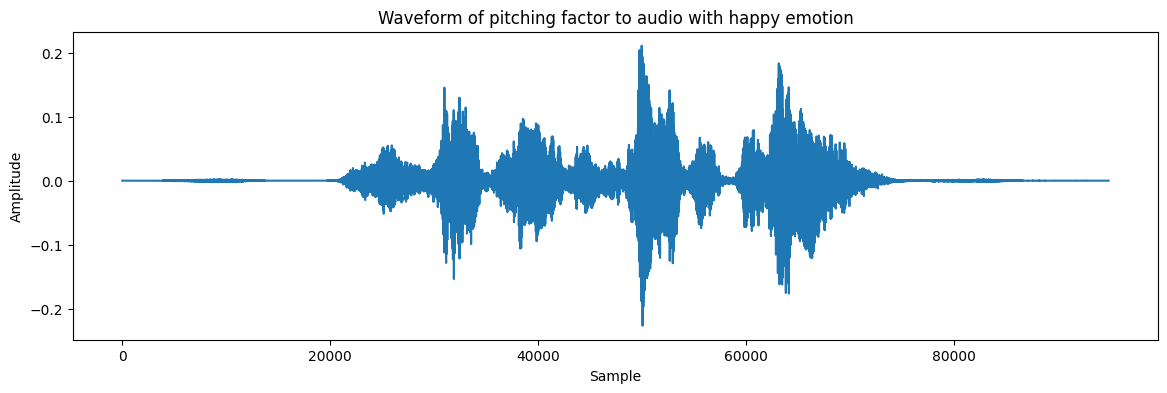

In [ ]:
pitch_factor = np.random.uniform(0.85, 1.15)
n_stepp = 12 * (pitch_factor - 1)

x = librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_stepp)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform of pitching factor to audio with {} emotion'.format(emotion))
plt.show()
Audio(x,rate=sampling_rate)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    pitch_factor = np.random.uniform(0.85, 1.15)
    n_stepp = 12 * (pitch_factor - 1)

    new_data = stretch(data)
    data_stretch_pitch = librosa.effects.pitch_shift(new_data, sr=sample_rate, n_steps=n_stepp)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

(14160, 14160, (4720,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.231839  0.514614  0.530323  0.598886  0.664504  0.661510  0.616012   
1  0.082515  0.615234  0.656125  0.694253  0.724847  0.712534  0.636055   
2  0.142011  0.627364  0.524571  0.515260  0.597120  0.647368  0.615735   
3  0.224781  0.610454  0.599744  0.685319  0.657021  0.608440  0.498562   
4  0.249715  0.619961  0.643649  0.725450  0.685274  0.663857  0.549388   

          7         8         9  ...       153       154       155       156  \
0  0.639412  0.737957  0.778719  ...  0.000147  0.000192  0.000154  0.000173   
1  0.654359  0.737445  0.755865  ...  0.000247  0.000292  0.000248  0.000266   
2  0.578290  0.626539  0.725655  ...  0.000025  0.000027  0.000020  0.000050   
3  0.507482  0.560148  0.553468  ...  0.000700  0.000870  0.000733  0.000642   
4  0.551139  0.566372  0.566062  ...  0.000754  0.000918  0.000801  0.000691   

        157       158       159       160       161    labels  
0  0.000159  0.000194  0.000274  0.000152  0.000015  surprise  
1  0.000240  0.000281  0.000346  0.000240  0.000099  surprise  
2  0.000035  0.000032  0.000050  0.000028  0.000002  surprise  
3  0.000802  0.000763  0.000936  0.000674  0.000066      fear  
4  0.000852  0.000808  0.000985  0.000708  0.000112      fear  

[5 rows x 163 columns]

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 162), (10620, 8), (3540, 162), (3540, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 162), (10620, 8), (3540, 162), (3540, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 162, 1), (10620, 8), (3540, 162, 1), (3540, 8))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 batch_normalization (Batch  (None, 162, 256)          1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 batch_normalization_1 (Bat  (None, 81, 256)           1024      
 chNormalization)                                                
                                                        

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.45, verbose=0, patience=3, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32, epochs=60, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/60
332/332 [==============================] - 12s 11ms/step - loss: 1.4795 - accuracy: 0.4479 - val_loss: 2.7367 - val_accuracy: 0.2638 - lr: 0.0010
Epoch 2/60
332/332 [==============================] - 3s 8ms/step - loss: 1.0950 - accuracy: 0.5889 - val_loss: 1.2532 - val_accuracy: 0.5158 - lr: 0.0010
Epoch 3/60
332/332 [==============================] - 3s 8ms/step - loss: 0.9917 - accuracy: 0.6266 - val_loss: 0.9378 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 4/60
332/332 [==============================] - 3s 8ms/step - loss: 0.9209 - accuracy: 0.6529 - val_loss: 1.3275 - val_accuracy: 0.5884 - lr: 0.0010
Epoch 5/60
332/332 [==============================] - 3s 8ms/step - loss: 0.8877 - accuracy: 0.6709 - val_loss: 0.7726 - val_accuracy: 0.7071 - lr: 0.0010
Epoch 6/60
332/332 [==============================] - 3s 8ms/step - loss: 0.8565 - accuracy: 0.6813 - val_loss: 1.3655 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 7/60
332/332 [==============================] - 3s 8ms/step - 

111/111 [==============================] - 0s 3ms/step - loss: 0.5565 - accuracy: 0.8506
Accuracy of our model on test data :  85.0564956665039 %


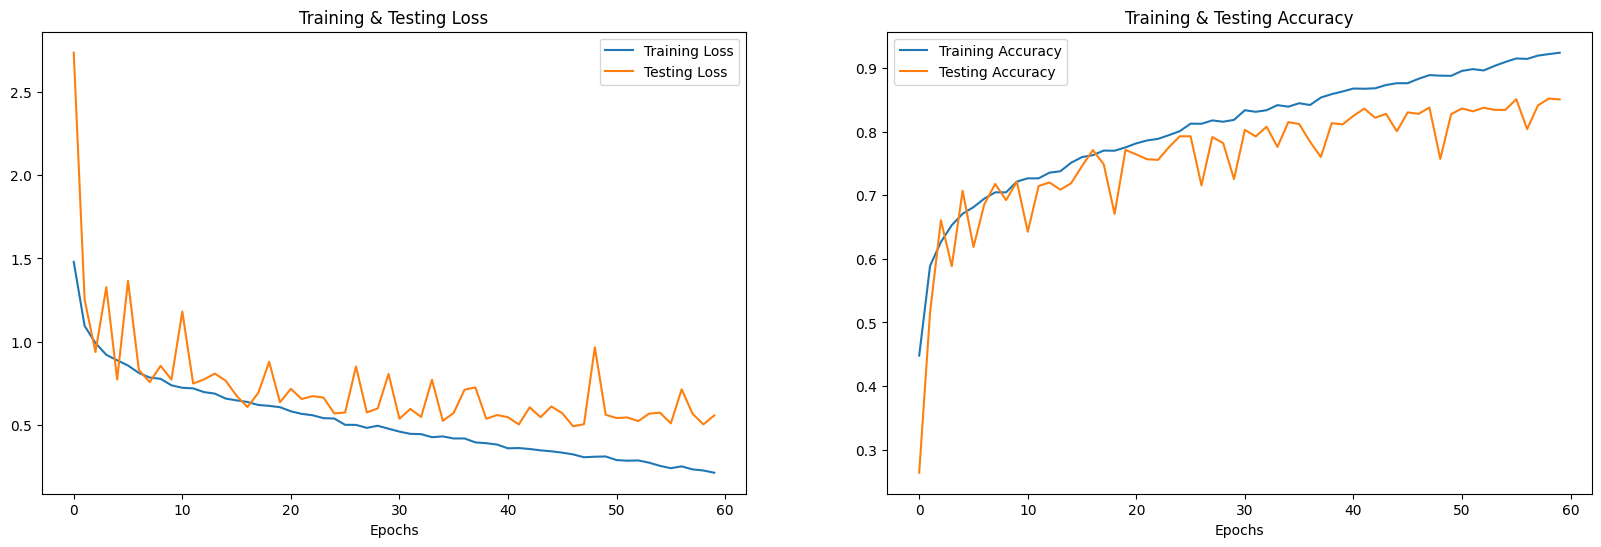

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

111/111 [==============================] - 0s 2ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head()

Predicted Labels Actual Labels
0            angry         angry
1         surprise      surprise
2            happy         happy
3          disgust       disgust
4         surprise         happy

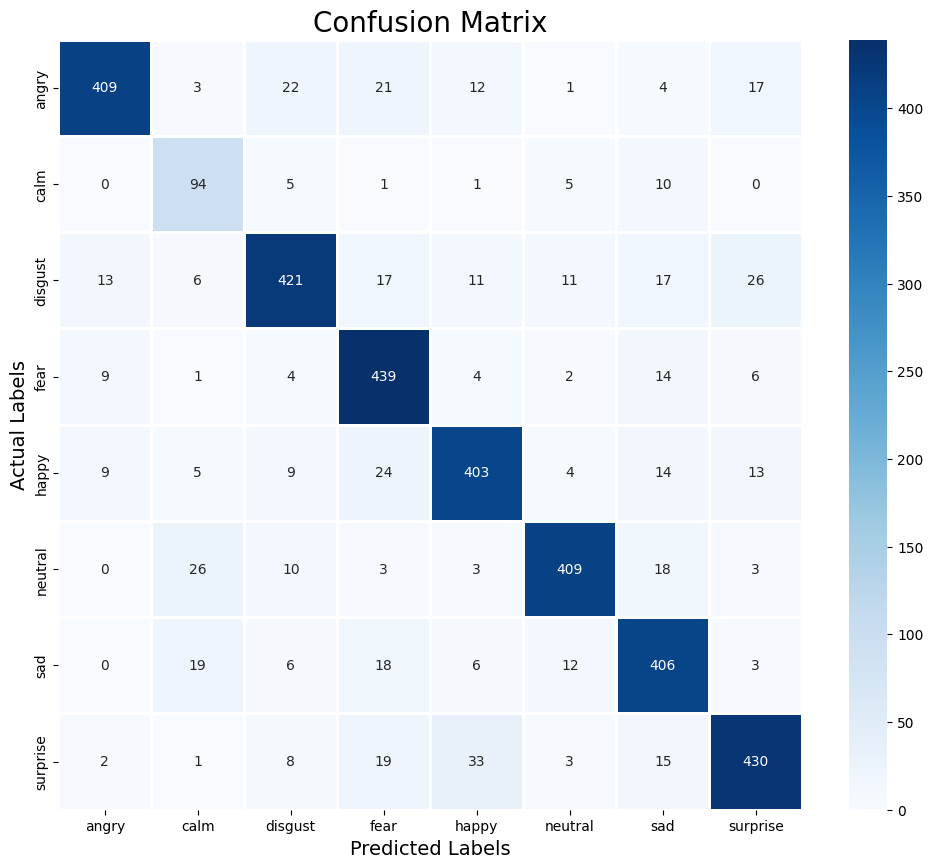

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

<ipython-input-138-2462324beb8a>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[macro_avg_precision, macro_avg_recall, macro_avg_f1_score], y=['Precision', 'Recall', 'F1 Score'], palette='viridis')
<ipython-input-138-2462324beb8a>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[weighted_avg_precision, weighted_avg_recall, weighted_avg_f1_score], y=['Precision', 'Recall', 'F1 Score'], palette='magma')


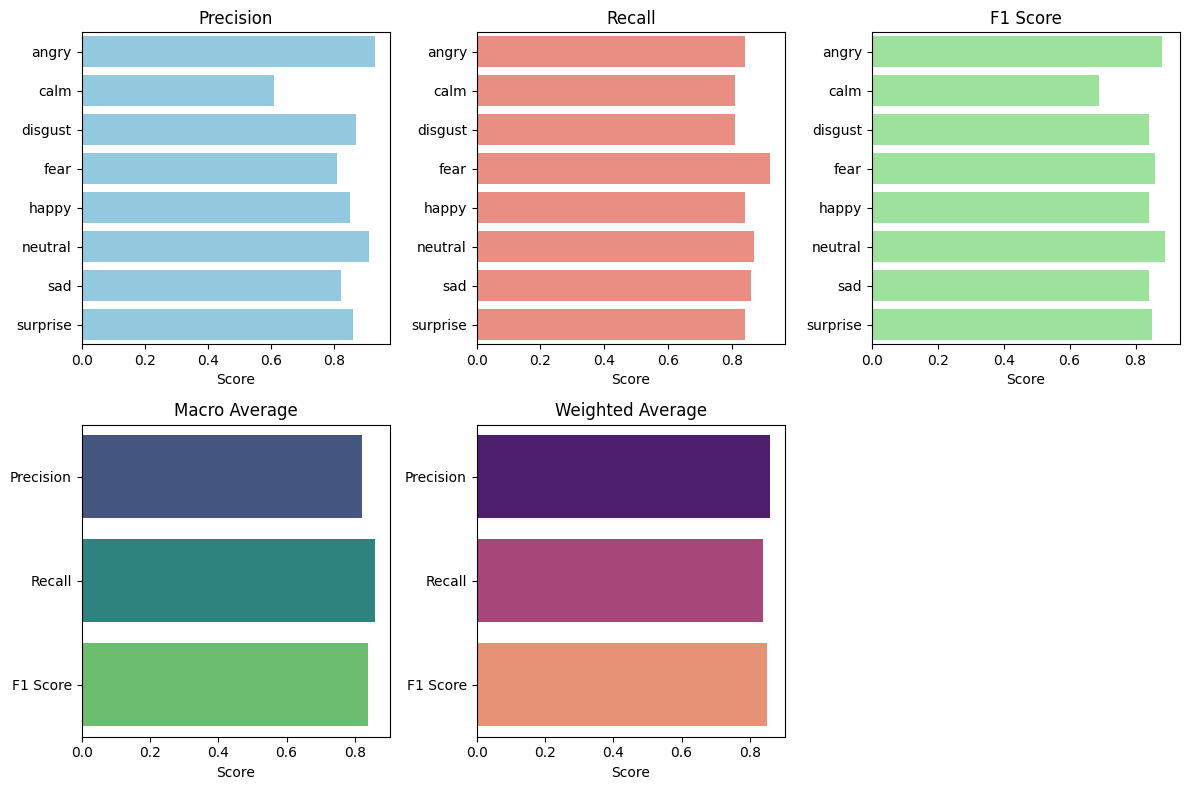

In [ ]:
report_str = classification_report(y_test, y_pred)

report_data = []
lines = report_str.split('\n')
for line in lines[2:-3]:
    row_data = line.split()
    if len(row_data) > 0:
        report_data.append(row_data)

# 排除 'accuracy'
labels = [row[0] for row in report_data if row[0] != 'accuracy']
precision = [float(row[1]) for row in report_data if len(row) > 1 and row[0] != 'accuracy']
recall = [float(row[2]) for row in report_data if len(row) > 2 and row[0] != 'accuracy']
f1_score_dict = {row[0]: float(row[3]) for row in report_data if len(row) > 3 and row[0] != 'accuracy'}

# 確保每個類別都有對應的 F1 分數
f1_score = [f1_score_dict[label] for label in labels]

macro_avg_precision = float(report_data[-3][1])
macro_avg_recall = float(report_data[-3][2])
macro_avg_f1_score = float(report_data[-3][3])

weighted_avg_precision = float(report_data[-2][1])
weighted_avg_recall = float(report_data[-2][2])
weighted_avg_f1_score = float(report_data[-2][3])

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
sns.barplot(x=precision, y=labels, color='skyblue')
plt.title('Precision')
plt.xlabel('Score')

plt.subplot(2, 3, 2)
sns.barplot(x=recall, y=labels, color='salmon')
plt.title('Recall')
plt.xlabel('Score')

plt.subplot(2, 3, 3)
sns.barplot(x=f1_score, y=labels, color='lightgreen')
plt.title('F1 Score')
plt.xlabel('Score')

plt.subplot(2, 3, 4)
sns.barplot(x=[macro_avg_precision, macro_avg_recall, macro_avg_f1_score], y=['Precision', 'Recall', 'F1 Score'], palette='viridis')
plt.title('Macro Average')
plt.xlabel('Score')

plt.subplot(2, 3, 5)
sns.barplot(x=[weighted_avg_precision, weighted_avg_recall, weighted_avg_f1_score], y=['Precision', 'Recall', 'F1 Score'], palette='magma')
plt.title('Weighted Average')
plt.xlabel('Score')

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.93      0.84      0.88       489
        calm       0.61      0.81      0.69       116
     disgust       0.87      0.81      0.84       522
        fear       0.81      0.92      0.86       479
       happy       0.85      0.84      0.84       481
     neutral       0.91      0.87      0.89       472
         sad       0.82      0.86      0.84       470
    surprise       0.86      0.84      0.85       511

    accuracy                           0.85      3540
   macro avg       0.83      0.85      0.84      3540
weighted avg       0.86      0.85      0.85      3540

